In [1]:
import keras
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, Conv2D, Flatten, BatchNormalization, Add, MaxPooling2D, AveragePooling2D, Dropout
import keras.backend as K
from keras.models import Model
from keras import regularizers
import sys
import random
from keras.utils import np_utils
sys.version

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarn

'3.5.2 (default, Oct  8 2019, 13:06:37) \n[GCC 5.4.0 20160609]'

# 构造恒等块

In [2]:
def identity_block(X, f, filters):
    '''
    X:输入向量，Tensor类型
    f:conv卷积核的维度
    filter:定义主路径上卷积核的个数
    '''
    F1, F2, F3 = filters
    X_shortcut = X
    #第一个卷积块
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer='glorot_uniform')(X)
    #归一化
    X = BatchNormalization(axis = 3)(X)
    #激活层
    X = Activation(activation='relu')(X)
    
    #第二个卷积块
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer='glorot_uniform')(X)
    #归一化
    X = BatchNormalization(axis=3)(X)
    #激活层
    X = Activation(activation='relu')(X)
    
    #第三个卷积块
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer='glorot_uniform')(X)
      #归一化
    X = BatchNormalization(axis=3)(X)
    
    #两条路径合并
    X = Add()([X, X_shortcut])
    #激活层
    X = Activation(activation='relu')(X)
    
    return X

#  构造卷积块

In [3]:
def conv_block(X, f, filters, s=2):
    '''
    X：输入向量
    f:卷积核的维度
    filters:各个组成块的卷积核的个数
    s:做卷积时的步伐
    '''
    F1, F2, F3 = filters
    #捷径
    X_shortcut = X
    #主路径
    #主路径的第一个卷积块
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation(activation='relu')(X)
    
    #主路径上的第二个卷积块
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation(activation='relu')(X)
    
    #主路径上的第三个卷积块
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3)(X)
    
    #捷径
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    
    #主路径捷径合并
    X = Add()([X, X_shortcut])
    X = Activation(activation='relu')(X)
    
    return X

# 构建残差网络

In [4]:
def ResNet(input_shape):
    '''
    input_shape:输入的Tensor维度
    
    '''
    X_input = Input(input_shape)
    #对输入数据进行零填充，padding=(3, 3)
    X = ZeroPadding2D(padding=(3, 3))(X_input)
    
    #state1
    '''
    卷积层有64个过滤器，其维度为（7，7），步伐为（2，2），命名为“conv1”

    规范层（BatchNorm）对输入数据进行通道轴归一化。

    最大值池化层使用一个（3，3）的窗口和（2，2）的步伐
    '''
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='valid', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)
    
    #state2
    '''

    卷积块使用f=3个大小为[64，64，256]的过滤器，f=3，s=1

    2个恒等块使用三个大小为[64，64，256]的过滤器，f=3

    '''
    X = conv_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256])
    X = identity_block(X, f=3, filters=[64, 64, 256])
    
    #state3
    '''

    卷积块使用f=3个大小为[128,128,512]的过滤器，f=3，s=2

    3个恒等块使用三个大小为[128,128,512]的过滤器，f=3

    '''
    X = conv_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    
    #state4
    '''
    卷积块使用f=3个大小为[256,256,1024]的过滤器，f=3，s=2

    5个恒等块使用三个大小为[256,256,1024]的过滤器，f=3
    
    '''
    X = conv_block(X, f=3, filters=[256, 256, 1024], s=2)
    
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    
    #state5
    '''
    卷积块使用f=3个大小为[512,512,2048]的过滤器，f=3，s=2

    2个恒等块使用三个大小为[256,256,2048]的过滤器，f=3
    '''
    X = conv_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, f=3, filters=[256, 256, 2048])
    X = identity_block(X, f=3, filters=[256, 256, 2048])
    
    #均值池化层
    '''
    均值池化层使用维度为（2,2）的窗口
    '''
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    #平滑
    X = Flatten()(X)
    
    '''
    全连接层
    使用softmax作为激活函数，输出为2,代表分类成两类的概率
    '''
    #将 softmax调换成sigmod 更适合二分类
    X = Dense(7, activation='softmax', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(2.0), activity_regularizer=regularizers.l1(2.0))(X)
    model = Model(inputs=X_input, outputs=X)
    
    return model

# 建立模型实例并编译

In [5]:
model = ResNet((60, 264, 1))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## 导入数据

In [6]:
import os
from scipy.io import loadmat
import numpy as np

In [7]:
path = r'/home/ubuntu/音频处理trainCqcc/'
list_root = os.listdir(path)

list_root

['ofile_time_stretch',
 'US_1',
 'SS_2',
 'VC_1',
 'SS_1',
 'bonafide',
 'VC_4',
 'SS_4',
 'ofile_time_roll']

In [8]:
Label = []
Data =[]
Label_dic = {'bonafide':0}
for path_children in list_root:
    if path_children =='ofile_time_roll' or path_children =='ofile_time_stretch' :#or path_children =='SS_4':
        continue
    if path_children in Label_dic:
        judge = Label_dic[path_children]
    else:
        judge = len(Label_dic)
        Label_dic[path_children] = judge

    path_children_ = path+path_children
    list_children = os.listdir(path_children_)
    dict_kind = {}
    
    if path_children not in dict_kind:
        dict_kind[path_children]=0
        
    #这里修改 一次读取特征文件数目    
    seq = [i for i in range(len(list_children))]
    choice  = random.sample(seq,2000)
    choice.sort()
    for number,mats in enumerate(list_children):
        if number not in choice:
            continue
        dict_kind[path_children]+=1
#         if dict_kind[path_children]>2000  and path_children !='bonafide' and path_children !='ofile_time_roll' and  path_children!='ofile_time_stretch':
#             break
#         elif dict_kind[path_children]>2000:
#             break
        Label.append(judge)
        m = loadmat(path_children_+'/'+mats)
        Data.append(m['CQcc'].reshape(60,264,1))

# Data = np.array(Data)

Data = (Data-Data.min())/(Data.max()-Data.min())

In [9]:
Label_dic

{'SS_1': 4,
 'SS_2': 2,
 'SS_4': 6,
 'US_1': 1,
 'VC_1': 3,
 'VC_4': 5,
 'bonafide': 0}

In [10]:
Data = np.array(Data)
Data.shape

(14000, 60, 264, 1)

In [11]:
Label = np.array(Label)
Label.shape

(14000,)

# 独热编码

In [12]:
y_train = np_utils.to_categorical(Label,num_classes= 7)
print(y_train[::100])
print(y_train.shape)

[[0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.

In [13]:
from sklearn.utils import shuffle
Data,y_train = shuffle(Data,y_train)

In [14]:
callbacks = [
    EarlyStopping(monitor='val_acc',patience=20),
    ModelCheckpoint('多分类.h5',monitor='val_acc',save_best_only=True,verbose=1),
    ]

In [15]:
train_history = model.fit(Data, y_train, epochs=8, batch_size=70, validation_split=0.2,callbacks=callbacks)

Train on 11200 samples, validate on 2800 samples
Epoch 1/8
11200/11200 [==============================] - 133s 12ms/step - loss: 144.3282 - acc: 0.6304 - val_loss: 144.6240 - val_acc: 0.1486

Epoch 00001: val_acc improved from -inf to 0.14857, saving model to 多分类.h5
Epoch 2/8
11200/11200 [==============================] - 127s 11ms/step - loss: 140.4090 - acc: 0.8991 - val_loss: 141.0263 - val_acc: 0.6743

Epoch 00002: val_acc improved from 0.14857 to 0.67429, saving model to 多分类.h5
Epoch 3/8
11200/11200 [==============================] - 126s 11ms/step - loss: 140.2032 - acc: 0.9621 - val_loss: 140.7095 - val_acc: 0.8268

Epoch 00003: val_acc improved from 0.67429 to 0.82679, saving model to 多分类.h5
Epoch 4/8
11200/11200 [==============================] - 126s 11ms/step - loss: 140.1995 - acc: 0.9701 - val_loss: 143.4048 - val_acc: 0.5593

Epoch 00004: val_acc did not improve
Epoch 5/8
11200/11200 [==============================] - 126s 11ms/step - loss: 140.1722 - acc: 0.9748 - val_lo

In [16]:
# define the function
def training_vis(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    ax2.plot(acc,label='train_acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy  on Training and Validation Data')
    ax2.legend()
    plt.tight_layout()

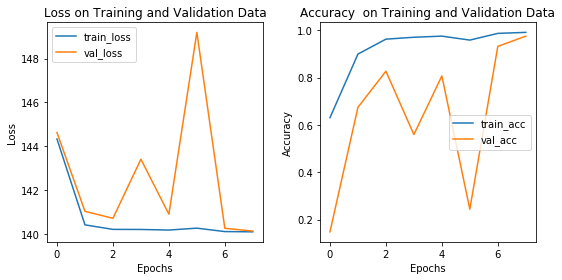

In [17]:
training_vis(train_history)

In [18]:
model = keras.models.load_model("多分类.h5")

# dev开发集

In [19]:
path = r'/home/ubuntu/音频处理devCqcc/'
list_root = os.listdir(path)

In [20]:
list_root

['US_1', 'SS_2', 'VC_1', 'SS_1', 'bonafide', 'VC_4', 'SS_4']

In [21]:
Label = []
Data =[]
Label_dic = {'bonafide':0}
for path_children in list_root:
    if path_children =='ofile_time_roll' or path_children =='ofile_time_stretch' :#or path_children =='SS_4':
        continue
    if path_children in Label_dic:
        judge = Label_dic[path_children]
    else:
        judge = len(Label_dic)
        Label_dic[path_children] = judge

    path_children_ = path+path_children
    list_children = os.listdir(path_children_)
    dict_kind = {}
    
    if path_children not in dict_kind:
        dict_kind[path_children]=0
        
        
    seq = [i for i in range(len(list_children))]
    choice  = random.sample(seq,1000)
    choice.sort()
    for number,mats in enumerate(list_children):
        if number not in choice:
            continue
        dict_kind[path_children]+=1
        Label.append(judge)
        m = loadmat(path_children_+'/'+mats)
        Data.append(m['CQcc'].reshape(60,264,1))

# Data = np.array(Data)

Data = (Data-Data.min())/(Data.max()-Data.min())

In [22]:
Label_dic

{'SS_1': 4,
 'SS_2': 2,
 'SS_4': 6,
 'US_1': 1,
 'VC_1': 3,
 'VC_4': 5,
 'bonafide': 0}

In [23]:
Data = np.array(Data)
Data.shape

(7000, 60, 264, 1)

In [24]:
Label = np.array(Label)
Label.shape

(7000,)

In [25]:
def transport(y):
    test_y = []
    for i in  y:
        max = np.argmax(i)
        if max == 0:
            test_y.append(max)
        else:
            test_y.append(1)
    return test_y

def transport1(y):
    test_y = []
    for i in  y:
        max = np.argmax(i)
        test_y.append(max)
    return test_y

def label_transport(label):
    test_y = []
    for i in  label:
        if i==0:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y

In [26]:
x_pre = model.predict(Data)

y_pre = transport(x_pre)
y_pre1 = transport1(x_pre)
y_true = label_transport(Label)

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def cm_plot(original_label, predict_label, pic=None):
    cm = confusion_matrix(original_label, predict_label)   # 由原标签和预测标签生成混淆矩阵
    plt.figure(figsize=(6,6.5))
    plt.matshow(cm, cmap=plt.cm.Blues)     # 画混淆矩阵，配色风格使用cm.Blues
    plt.colorbar()    # 颜色标签
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
            # annotate主要在图形中添加注释
            # 第一个参数添加注释
            # 第二个参数是注释的内容
            # xy设置箭头尖的坐标
            # horizontalalignment水平对齐
            # verticalalignment垂直对齐
            # 其余常用参数如下：
            # xytext设置注释内容显示的起始位置
            # arrowprops 用来设置箭头
            # facecolor 设置箭头的颜色
            # headlength 箭头的头的长度
            # headwidth 箭头的宽度
            # width 箭身的宽度
    plt.ylabel('True label')  # 坐标轴标签
    plt.xlabel('Predicted label')  # 坐标轴标签
    plt.title('confusion matrix')
    if pic is not None:
        plt.savefig(str(pic) + '.jpg')
    plt.show()


<Figure size 432x468 with 0 Axes>

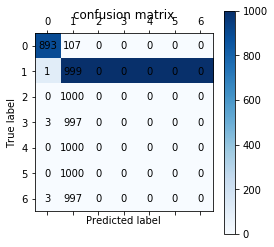

In [28]:
cm_plot(y_pre,Label)

<Figure size 432x468 with 0 Axes>

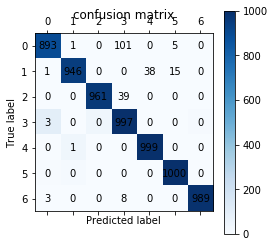

In [29]:
cm_plot(y_pre1,Label)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,accuracy_score
from sklearn.metrics import precision_score,f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [31]:
# micro：多分类　　
# weighted：不均衡数量的类来说，计算二分类metrics的平均
# macro：计算二分类metrics的均值，为每个类给出相同权重的分值。
precision = precision_score(Label, y_pre, average='weighted')
recall = recall_score(Label, y_pre, average='weighted')
f1_score = f1_score(Label, y_pre, average='weighted')
accuracy_score = accuracy_score(Label, y_pre)
print("Precision_score:",precision)
print("Recall_score:",recall)
print("F1_score:",f1_score)
print("Accuracy_score:",accuracy_score)



# # 二分类　ＲＯＣ曲线
# # roc_curve:真正率（True Positive Rate , TPR）或灵敏度（sensitivity）
# # 横坐标：假正率（False Positive Rate , FPR）
# fpr, tpr, thresholds_keras = roc_curve(Label, y_pre)
# auc = auc(fpr, tpr)
# print("AUC : ", auc)
# plt.figure()
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.savefig("../ROC_2分类.png")
# plt.show()

Precision_score: 0.16514181628935726
Recall_score: 0.2702857142857143
F1_score: 0.17448692152917508
Accuracy_score: 0.2702857142857143


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
print((y_pre1 == Label).sum(),"+++",len(y_pre))


print((y_pre1 == Label).sum()/len(y_pre))
#print((y_pre1 == y_true).sum()/len(y_pre))

6785 +++ 7000
0.9692857142857143


# 评估集！！！

In [59]:
path = r'/home/ubuntu/音频处理evalCqcc/'
list_root = os.listdir(path)

In [60]:
list_root

['A16',
 'A14',
 'A11',
 'A13',
 'A12',
 'A07',
 'A08',
 'bonafide',
 'A19',
 'A17',
 'A15',
 'A18',
 'A09',
 'A10']

In [61]:
Label = []
Data =[]
Label_dic = {'bonafide':0}
for path_children in list_root:
    if path_children =='ofile_time_roll' or path_children =='ofile_time_stretch':
        continue
    if path_children in Label_dic:
        judge = Label_dic[path_children]
    else:
        judge = len(Label_dic)
        Label_dic[path_children] = judge

    path_children_ = path+path_children
    list_children = os.listdir(path_children_)
    dict_kind = {}
    
    if path_children not in dict_kind:
        dict_kind[path_children]=0
        
    for mats in list_children:
        dict_kind[path_children]+=1
#         if dict_kind[path_children]>2000  and path_children !='bonafide' and path_children !='ofile_time_roll' and  path_children!='ofile_time_stretch':
#             break
        if dict_kind[path_children]>2000:
            break
        Label.append(judge)
        m = loadmat(path_children_+'/'+mats)
        Data.append(m['CQcc'].reshape(60,264,1))

In [62]:
Data = np.array(Data)
Data.shape

(28000, 60, 264, 1)

In [63]:
Label = np.array(Label)
Label.shape

(28000,)

In [64]:
def transport(y):
    test_y = []
    for i in  y:
        max = np.argmax(i)
        if max == 0:
            test_y.append(max)
        else:
            test_y.append(1)
    return test_y

def transport1(y):
    test_y = []
    for i in  y:
        if i[0]>0.90:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y

def label_transport(label):
    test_y = []
    for i in  label:
        if i==0:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y


In [65]:
x_pre = model.predict(Data)

In [66]:
y_pre = transport(x_pre)
y_pre1 = transport1(x_pre)
y_true = label_transport(Label)

In [67]:
Label[::500]

array([ 1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  5,
        5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  0,  0,  0,  0,  8,  8,
        8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 13, 13, 13, 13])

In [68]:
y_true[::500]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

<Figure size 432x468 with 0 Axes>

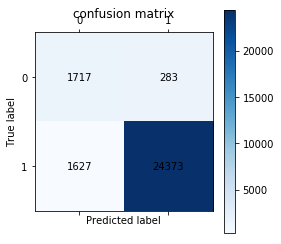

In [69]:
cm_plot(y_pre,y_true)

<Figure size 432x468 with 0 Axes>

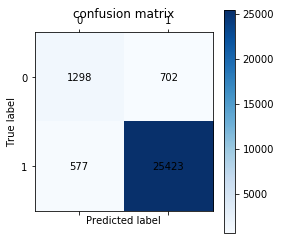

In [70]:
cm_plot(y_pre1,y_true)

In [71]:
# micro：多分类　　
# weighted：不均衡数量的类来说，计算二分类metrics的平均
# macro：计算二分类metrics的均值，为每个类给出相同权重的分值。
precision = precision_score(y_pre1,y_true, average='weighted')
recall = recall_score(y_pre1,y_true, average='weighted')
# f1_score = f1_score(y_pre1,y_true, average='weighted')
# accuracy_score = accuracy_score(y_pre1,y_true)
print("Precision_score:",precision)
print("Recall_score:",recall)
print("F1_score:",f1_score)
print("Accuracy_score:",accuracy_score)



# # 二分类　ＲＯＣ曲线
# # roc_curve:真正率（True Positive Rate , TPR）或灵敏度（sensitivity）
# # 横坐标：假正率（False Positive Rate , FPR）
# fpr, tpr, thresholds_keras = roc_curve(Label, y_pre1)
# auc = auc(fpr, tpr)
# print("AUC : ", auc)
# plt.figure()
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.savefig("../ROC_2分类.png")
# plt.show()

Precision_score: 0.955789320054945
Recall_score: 0.9543214285714285
F1_score: 0.17448692152917508
Accuracy_score: 0.2702857142857143


# 每种攻击测试

In [72]:
path = r'/home/ubuntu/音频处理evalCqcc/'
list_root = os.listdir(path)

In [73]:
list_root

['A16',
 'A14',
 'A11',
 'A13',
 'A12',
 'A07',
 'A08',
 'bonafide',
 'A19',
 'A17',
 'A15',
 'A18',
 'A09',
 'A10']

In [74]:
def transport(y):
    test_y = []
    for i in  y:
        max = np.argmax(i)
        if max == 0:
            test_y.append(max)
        else:
            test_y.append(1)
    return test_y

def transport1(y):
    test_y = []
    for i in  y:
        if i[0]>0.80:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y

def label_transport(label):
    test_y = []
    for i in  label:
        if i==0:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y


In [75]:
for c,path_children in  enumerate(list_root):
    Label = []
    Data =[]
    print(path_children)
    if path_children =='bonafide' or path_children =='ofile_time_roll' or  path_children=='ofile_time_stretch':
        judge = 0
    else:
#         continue
        judge = 1
        
    path_children_ = path+path_children
    list_children = os.listdir(path_children_)
    dict_kind = {}
    
    if path_children not in dict_kind:
        dict_kind[path_children]=0
        
    for mats in list_children:
        dict_kind[path_children]+=1
        if dict_kind[path_children]>1000  and path_children !='bonafide' and path_children !='ofile_time_roll' and  path_children!='ofile_time_stretch':
            break
        elif dict_kind[path_children]>1000:
            break
        Label.append(judge)
        m = loadmat(path_children_+'/'+mats)
        Data.append(m['CQcc'].reshape(60,264,1))
    Data = np.array(Data)
    Label = np.array(Label)
    x_pre = model.predict(Data)
    y_pre = transport(x_pre)
    y_pre1 = transport1(x_pre)
    y_true = label_transport(Label)
    print((y_pre == Label).sum()/len(y_pre),"++++",np.array(np.array(y_pre1) == np.array(y_true)).sum()/len(y_pre1))

A16
0.998 ++++ 1.0
A14
0.981 ++++ 0.998
A11
0.995 ++++ 1.0
A13
0.987 ++++ 0.998
A12
0.973 ++++ 0.998
A07
1.0 ++++ 1.0
A08
0.98 ++++ 0.999
bonafide
0.85 ++++ 0.738
A19
1.0 ++++ 1.0
A17
0.615 ++++ 0.766
A15
0.991 ++++ 1.0
A18
0.65 ++++ 0.807
A09
1.0 ++++ 1.0
A10
0.985 ++++ 0.998


In [76]:
model.save('最终保留.h5')